In [32]:
from datasets import load_dataset

# Load WikiText-2 (or use 'wikitext', 'wikitext-103-raw-v1', etc.)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Check available splits
print(dataset)


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [34]:
# Save to a .txt file for training with transformers
with open("wikitext_train.txt1", "w", encoding="utf-8") as f:
    f.write(full_text)

print("✅ WikiText saved as 'wikitext_train.txt1' for fine-tuning.")

✅ WikiText saved as 'wikitext_train.txt1' for fine-tuning.


In [35]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load dataset from your saved file
dataset = load_dataset("text", data_files={"train": "wikitext_train.txt"})

# Load GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# GPT-2 doesn't have pad token by default
tokenizer.pad_token = tokenizer.eos_token

# Tokenize in chunks for efficient training
def tokenize_function(examples):
    return tokenizer(examples["text"], return_special_tokens_mask=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])


In [36]:
block_size = 128  # You can increase this if GPU allows

def group_texts(examples):
    # Concatenate input_ids and attention_mask separately
    concatenated_input_ids = sum(examples["input_ids"], [])
    concatenated_attention_mask = sum(examples["attention_mask"], [])

    total_length = (len(concatenated_input_ids) // block_size) * block_size

    result = {
        "input_ids": [concatenated_input_ids[i:i + block_size] for i in range(0, total_length, block_size)],
        "attention_mask": [concatenated_attention_mask[i:i + block_size] for i in range(0, total_length, block_size)],
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [37]:
tokenized_datasets = tokenized_datasets.remove_columns(['special_tokens_mask'])

In [38]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

In [39]:
from transformers import (
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

# Data collator for causal language modeling (CLM)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal LM like GPT-2 does NOT use masked LM
)
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2-wikitext",
    save_strategy="epoch",         # Save a checkpoint at the end of every epoch
    evaluation_strategy="epoch",   # Evaluate at the end of every epoch
    save_total_limit=3,            # Keep only last 3 checkpoints to save space
    logging_dir="./gpt2-wikitext/runs",
    logging_steps=100,
    per_device_train_batch_size=4,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,   # Optional: load best checkpoint at end
    metric_for_best_model="eval_loss",  # If using above
)



In [40]:
from datasets import DatasetDict

# Split 90% train, 10% validation
split_datasets = lm_datasets["train"].train_test_split(test_size=0.1, seed=42)

# Create a new DatasetDict
lm_datasets = DatasetDict({
    "train": split_datasets["train"],
    "validation": split_datasets["test"]
})


In [41]:
from transformers import AutoModelForCausalLM
from transformers import Trainer, EarlyStoppingCallback

# Load pre-trained GPT-2 model
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[],
)

# Start training
trainer.train()


/home/dharun/Desktop/wikitext/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/41230 [00:00<?, ?it/s]

{'loss': 3.9825, 'grad_norm': 8.582462310791016, 'learning_rate': 4.988236720834344e-05, 'epoch': 0.02}
{'loss': 3.8027, 'grad_norm': 7.362393379211426, 'learning_rate': 4.976109628910988e-05, 'epoch': 0.05}
{'loss': 3.7593, 'grad_norm': 5.146574974060059, 'learning_rate': 4.963982536987631e-05, 'epoch': 0.07}
{'loss': 3.7591, 'grad_norm': 4.38360071182251, 'learning_rate': 4.951855445064274e-05, 'epoch': 0.1}
{'loss': 3.7176, 'grad_norm': 3.6441469192504883, 'learning_rate': 4.9397283531409175e-05, 'epoch': 0.12}
{'loss': 3.7069, 'grad_norm': 4.22341251373291, 'learning_rate': 4.927601261217561e-05, 'epoch': 0.15}
{'loss': 3.6621, 'grad_norm': 3.9211137294769287, 'learning_rate': 4.915474169294203e-05, 'epoch': 0.17}
{'loss': 3.6275, 'grad_norm': 3.685277223587036, 'learning_rate': 4.9033470773708465e-05, 'epoch': 0.19}
{'loss': 3.6197, 'grad_norm': 3.665036201477051, 'learning_rate': 4.89121998544749e-05, 'epoch': 0.22}
{'loss': 3.6384, 'grad_norm': 3.3806347846984863, 'learning_rate

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.3891992568969727, 'eval_runtime': 5.6829, 'eval_samples_per_second': 322.546, 'eval_steps_per_second': 40.472, 'epoch': 1.0}
{'loss': 3.2996, 'grad_norm': 2.9380970001220703, 'learning_rate': 4.491025951976716e-05, 'epoch': 1.02}
{'loss': 3.2132, 'grad_norm': 2.922483444213867, 'learning_rate': 4.4788988600533595e-05, 'epoch': 1.04}
{'loss': 3.234, 'grad_norm': 3.0767643451690674, 'learning_rate': 4.466771768130003e-05, 'epoch': 1.07}
{'loss': 3.2657, 'grad_norm': 3.6621267795562744, 'learning_rate': 4.454644676206646e-05, 'epoch': 1.09}
{'loss': 3.2458, 'grad_norm': 3.0786728858947754, 'learning_rate': 4.442517584283289e-05, 'epoch': 1.12}
{'loss': 3.2603, 'grad_norm': 3.0233826637268066, 'learning_rate': 4.4303904923599324e-05, 'epoch': 1.14}
{'loss': 3.2522, 'grad_norm': 3.3117237091064453, 'learning_rate': 4.4182634004365756e-05, 'epoch': 1.16}
{'loss': 3.2427, 'grad_norm': 3.97981858253479, 'learning_rate': 4.406136308513219e-05, 'epoch': 1.19}
{'loss': 3.2476, 'gr

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.341003894805908, 'eval_runtime': 5.7234, 'eval_samples_per_second': 320.264, 'eval_steps_per_second': 40.186, 'epoch': 2.0}
{'loss': 3.1217, 'grad_norm': 2.984219551086426, 'learning_rate': 3.994178995876789e-05, 'epoch': 2.01}
{'loss': 3.0189, 'grad_norm': 2.909242868423462, 'learning_rate': 3.982051903953432e-05, 'epoch': 2.04}
{'loss': 2.9987, 'grad_norm': 3.18302845954895, 'learning_rate': 3.9699248120300755e-05, 'epoch': 2.06}
{'loss': 3.0081, 'grad_norm': 3.0646352767944336, 'learning_rate': 3.957797720106719e-05, 'epoch': 2.09}
{'loss': 3.0068, 'grad_norm': 2.830808162689209, 'learning_rate': 3.945670628183362e-05, 'epoch': 2.11}
{'loss': 3.0328, 'grad_norm': 3.1983017921447754, 'learning_rate': 3.933543536260005e-05, 'epoch': 2.13}
{'loss': 3.0294, 'grad_norm': 3.037949323654175, 'learning_rate': 3.921416444336648e-05, 'epoch': 2.16}
{'loss': 3.0286, 'grad_norm': 2.948638916015625, 'learning_rate': 3.9092893524132916e-05, 'epoch': 2.18}
{'loss': 3.0714, 'grad_no

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.3271853923797607, 'eval_runtime': 5.7566, 'eval_samples_per_second': 318.417, 'eval_steps_per_second': 39.954, 'epoch': 3.0}
{'loss': 3.0238, 'grad_norm': 2.9166650772094727, 'learning_rate': 3.4970894979383944e-05, 'epoch': 3.01}
{'loss': 2.8521, 'grad_norm': 3.015981912612915, 'learning_rate': 3.4849624060150376e-05, 'epoch': 3.03}
{'loss': 2.8501, 'grad_norm': 2.9870593547821045, 'learning_rate': 3.472835314091681e-05, 'epoch': 3.06}
{'loss': 2.8567, 'grad_norm': 3.2461535930633545, 'learning_rate': 3.460708222168324e-05, 'epoch': 3.08}
{'loss': 2.8803, 'grad_norm': 3.1248409748077393, 'learning_rate': 3.448581130244967e-05, 'epoch': 3.1}
{'loss': 2.8897, 'grad_norm': 3.0011448860168457, 'learning_rate': 3.4364540383216105e-05, 'epoch': 3.13}
{'loss': 2.8755, 'grad_norm': 3.0243380069732666, 'learning_rate': 3.4243269463982544e-05, 'epoch': 3.15}
{'loss': 2.9391, 'grad_norm': 3.3147521018981934, 'learning_rate': 3.4121998544748976e-05, 'epoch': 3.18}
{'loss': 2.8827,

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.3367063999176025, 'eval_runtime': 5.6759, 'eval_samples_per_second': 322.947, 'eval_steps_per_second': 40.523, 'epoch': 4.0}
{'loss': 2.9259, 'grad_norm': 3.141570806503296, 'learning_rate': 3.0001212709192338e-05, 'epoch': 4.0}
{'loss': 2.747, 'grad_norm': 3.310432195663452, 'learning_rate': 2.987994178995877e-05, 'epoch': 4.03}
{'loss': 2.7209, 'grad_norm': 3.451183319091797, 'learning_rate': 2.9758670870725202e-05, 'epoch': 4.05}
{'loss': 2.7143, 'grad_norm': 3.403521776199341, 'learning_rate': 2.9637399951491635e-05, 'epoch': 4.07}
{'loss': 2.7582, 'grad_norm': 3.2812118530273438, 'learning_rate': 2.9516129032258067e-05, 'epoch': 4.1}
{'loss': 2.7694, 'grad_norm': 2.9627487659454346, 'learning_rate': 2.93948581130245e-05, 'epoch': 4.12}
{'loss': 2.7372, 'grad_norm': 3.3094329833984375, 'learning_rate': 2.927358719379093e-05, 'epoch': 4.15}
{'loss': 2.7323, 'grad_norm': 3.357057809829712, 'learning_rate': 2.915231627455736e-05, 'epoch': 4.17}
{'loss': 2.7482, 'grad_n

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.3621511459350586, 'eval_runtime': 5.6076, 'eval_samples_per_second': 326.876, 'eval_steps_per_second': 41.016, 'epoch': 5.0}
{'loss': 2.6482, 'grad_norm': 3.418459892272949, 'learning_rate': 2.491025951976716e-05, 'epoch': 5.02}
{'loss': 2.6287, 'grad_norm': 3.3942832946777344, 'learning_rate': 2.4788988600533593e-05, 'epoch': 5.04}
{'loss': 2.6265, 'grad_norm': 3.5114853382110596, 'learning_rate': 2.4667717681300025e-05, 'epoch': 5.07}
{'loss': 2.6224, 'grad_norm': 3.717043876647949, 'learning_rate': 2.4546446762066458e-05, 'epoch': 5.09}
{'loss': 2.6459, 'grad_norm': 3.5114428997039795, 'learning_rate': 2.442517584283289e-05, 'epoch': 5.12}
{'loss': 2.6323, 'grad_norm': 3.2653098106384277, 'learning_rate': 2.4303904923599322e-05, 'epoch': 5.14}
{'loss': 2.6639, 'grad_norm': 3.397864580154419, 'learning_rate': 2.4182634004365754e-05, 'epoch': 5.17}
{'loss': 2.6253, 'grad_norm': 3.3818018436431885, 'learning_rate': 2.4061363085132187e-05, 'epoch': 5.19}
{'loss': 2.6463,

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.3773560523986816, 'eval_runtime': 5.9097, 'eval_samples_per_second': 310.167, 'eval_steps_per_second': 38.919, 'epoch': 6.0}
{'loss': 2.616, 'grad_norm': 3.355942964553833, 'learning_rate': 1.9940577249575555e-05, 'epoch': 6.02}
{'loss': 2.5665, 'grad_norm': 3.249361276626587, 'learning_rate': 1.9819306330341987e-05, 'epoch': 6.04}
{'loss': 2.5482, 'grad_norm': 3.4991884231567383, 'learning_rate': 1.9698035411108416e-05, 'epoch': 6.06}
{'loss': 2.6047, 'grad_norm': 3.308015823364258, 'learning_rate': 1.9576764491874848e-05, 'epoch': 6.09}
{'loss': 2.5784, 'grad_norm': 3.3847591876983643, 'learning_rate': 1.945549357264128e-05, 'epoch': 6.11}
{'loss': 2.5427, 'grad_norm': 3.7504875659942627, 'learning_rate': 1.9334222653407713e-05, 'epoch': 6.14}
{'loss': 2.555, 'grad_norm': 3.4608957767486572, 'learning_rate': 1.9212951734174145e-05, 'epoch': 6.16}
{'loss': 2.5773, 'grad_norm': 3.5359411239624023, 'learning_rate': 1.9091680814940577e-05, 'epoch': 6.18}
{'loss': 2.5797, 

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.404364585876465, 'eval_runtime': 5.6591, 'eval_samples_per_second': 323.903, 'eval_steps_per_second': 40.642, 'epoch': 7.0}
{'loss': 2.5178, 'grad_norm': 3.4076168537139893, 'learning_rate': 1.4970894979383945e-05, 'epoch': 7.01}
{'loss': 2.479, 'grad_norm': 3.32916522026062, 'learning_rate': 1.4849624060150378e-05, 'epoch': 7.03}
{'loss': 2.4874, 'grad_norm': 3.55690336227417, 'learning_rate': 1.4728353140916808e-05, 'epoch': 7.06}
{'loss': 2.4676, 'grad_norm': 3.5947349071502686, 'learning_rate': 1.460708222168324e-05, 'epoch': 7.08}
{'loss': 2.5088, 'grad_norm': 3.3430283069610596, 'learning_rate': 1.4485811302449673e-05, 'epoch': 7.11}
{'loss': 2.5154, 'grad_norm': 3.6195433139801025, 'learning_rate': 1.4364540383216105e-05, 'epoch': 7.13}
{'loss': 2.517, 'grad_norm': 3.563302516937256, 'learning_rate': 1.4243269463982536e-05, 'epoch': 7.15}
{'loss': 2.5025, 'grad_norm': 4.128068447113037, 'learning_rate': 1.4121998544748971e-05, 'epoch': 7.18}
{'loss': 2.5018, 'gra

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.425924062728882, 'eval_runtime': 6.1713, 'eval_samples_per_second': 297.02, 'eval_steps_per_second': 37.269, 'epoch': 8.0}
{'loss': 2.5084, 'grad_norm': 3.6826868057250977, 'learning_rate': 1.0001212709192336e-05, 'epoch': 8.0}
{'loss': 2.471, 'grad_norm': 3.6634066104888916, 'learning_rate': 9.879941789958768e-06, 'epoch': 8.03}
{'loss': 2.4209, 'grad_norm': 3.809814453125, 'learning_rate': 9.7586708707252e-06, 'epoch': 8.05}
{'loss': 2.3824, 'grad_norm': 3.3706302642822266, 'learning_rate': 9.637399951491633e-06, 'epoch': 8.08}
{'loss': 2.4823, 'grad_norm': 3.6384518146514893, 'learning_rate': 9.516129032258064e-06, 'epoch': 8.1}
{'loss': 2.479, 'grad_norm': 3.6899256706237793, 'learning_rate': 9.394858113024497e-06, 'epoch': 8.13}
{'loss': 2.4645, 'grad_norm': 3.3045918941497803, 'learning_rate': 9.27358719379093e-06, 'epoch': 8.15}
{'loss': 2.4651, 'grad_norm': 3.6327335834503174, 'learning_rate': 9.152316274557362e-06, 'epoch': 8.17}
{'loss': 2.4775, 'grad_norm': 3

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.4471893310546875, 'eval_runtime': 5.8277, 'eval_samples_per_second': 314.532, 'eval_steps_per_second': 39.467, 'epoch': 9.0}
{'loss': 2.3823, 'grad_norm': 3.745629072189331, 'learning_rate': 4.91025951976716e-06, 'epoch': 9.02}
{'loss': 2.4178, 'grad_norm': 3.331587314605713, 'learning_rate': 4.788988600533592e-06, 'epoch': 9.05}
{'loss': 2.3952, 'grad_norm': 3.574631929397583, 'learning_rate': 4.6677176813000245e-06, 'epoch': 9.07}
{'loss': 2.4372, 'grad_norm': 3.635157823562622, 'learning_rate': 4.546446762066457e-06, 'epoch': 9.1}
{'loss': 2.435, 'grad_norm': 3.66192626953125, 'learning_rate': 4.425175842832889e-06, 'epoch': 9.12}
{'loss': 2.4319, 'grad_norm': 3.744255781173706, 'learning_rate': 4.303904923599321e-06, 'epoch': 9.14}
{'loss': 2.4258, 'grad_norm': 3.6447808742523193, 'learning_rate': 4.1826340043657536e-06, 'epoch': 9.17}
{'loss': 2.3891, 'grad_norm': 4.156301975250244, 'learning_rate': 4.061363085132185e-06, 'epoch': 9.19}
{'loss': 2.4566, 'grad_norm'

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.466836929321289, 'eval_runtime': 6.1701, 'eval_samples_per_second': 297.08, 'eval_steps_per_second': 37.277, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


{'train_runtime': 4081.7739, 'train_samples_per_second': 40.404, 'train_steps_per_second': 10.101, 'train_loss': 2.8179512214521862, 'epoch': 10.0}


TrainOutput(global_step=41230, training_loss=2.8179512214521862, metrics={'train_runtime': 4081.7739, 'train_samples_per_second': 40.404, 'train_steps_per_second': 10.101, 'total_flos': 1.077307047936e+16, 'train_loss': 2.8179512214521862, 'epoch': 10.0})

In [42]:
from transformers import GPT2Config, GPT2LMHeadModel

# Load GPT2 config with dropout
config = GPT2Config.from_pretrained(
    "gpt2",
    attn_pdrop=0.3,     # Dropout in attention layers
    resid_pdrop=0.3,    # Dropout in residual connections
    embd_pdrop=0.3      # Dropout in embedding layers
)

# Load model with the modified config
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)


/home/dharun/Desktop/wikitext/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [43]:
print("Dropout settings:")
print("Attention dropout:", model.config.attn_pdrop)
print("Residual dropout:", model.config.resid_pdrop)
print("Embedding dropout:", model.config.embd_pdrop)


Dropout settings:
Attention dropout: 0.3
Residual dropout: 0.3
Embedding dropout: 0.3


In [54]:
training_args = TrainingArguments(
    output_dir="./gpt2-wikitext",
    per_device_train_batch_size=4,
    num_train_epochs=10,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_dir="./gpt2-wikitext/logs",
    logging_steps=100,
    learning_rate=3e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,  # gradient clipping
    lr_scheduler_type="cosine",
    warmup_steps=200
)



In [55]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# 9. Train
trainer.train()

  0%|          | 0/41230 [00:00<?, ?it/s]

{'loss': 3.6815, 'grad_norm': 3.642857789993286, 'learning_rate': 1.5e-05, 'epoch': 0.02}
{'loss': 3.6198, 'grad_norm': 3.91172456741333, 'learning_rate': 2.985e-05, 'epoch': 0.05}
{'loss': 3.5843, 'grad_norm': 3.7768661975860596, 'learning_rate': 2.999956905059594e-05, 'epoch': 0.07}
{'loss': 3.5989, 'grad_norm': 3.631192207336426, 'learning_rate': 2.9998258771667468e-05, 'epoch': 0.1}
{'loss': 3.5708, 'grad_norm': 3.604297637939453, 'learning_rate': 2.9996069196061623e-05, 'epoch': 0.12}
{'loss': 3.5724, 'grad_norm': 3.6123387813568115, 'learning_rate': 2.999300045214573e-05, 'epoch': 0.15}
{'loss': 3.53, 'grad_norm': 3.571381092071533, 'learning_rate': 2.998905271982977e-05, 'epoch': 0.17}
{'loss': 3.5002, 'grad_norm': 3.547060251235962, 'learning_rate': 2.9984226230555803e-05, 'epoch': 0.19}
{'loss': 3.5068, 'grad_norm': 3.5458881855010986, 'learning_rate': 2.9978521267284406e-05, 'epoch': 0.22}
{'loss': 3.5198, 'grad_norm': 3.423762559890747, 'learning_rate': 2.997193816447809e-05

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.4571456909179688, 'eval_runtime': 5.7925, 'eval_samples_per_second': 316.442, 'eval_steps_per_second': 39.706, 'epoch': 1.0}
{'loss': 3.4144, 'grad_norm': 3.485236406326294, 'learning_rate': 2.9302652172045038e-05, 'epoch': 1.02}
{'loss': 3.3766, 'grad_norm': 3.5820863246917725, 'learning_rate': 2.926762126422398e-05, 'epoch': 1.04}
{'loss': 3.3882, 'grad_norm': 3.5894737243652344, 'learning_rate': 2.9231753894506733e-05, 'epoch': 1.07}
{'loss': 3.4319, 'grad_norm': 4.0688958168029785, 'learning_rate': 2.919505216567465e-05, 'epoch': 1.09}
{'loss': 3.4084, 'grad_norm': 3.598224401473999, 'learning_rate': 2.9157518229424728e-05, 'epoch': 1.12}
{'loss': 3.4297, 'grad_norm': 3.456059694290161, 'learning_rate': 2.9119154286243426e-05, 'epoch': 1.14}
{'loss': 3.4222, 'grad_norm': 3.7296316623687744, 'learning_rate': 2.907996258527768e-05, 'epoch': 1.16}
{'loss': 3.4116, 'grad_norm': 3.5644776821136475, 'learning_rate': 2.9039945424203047e-05, 'epoch': 1.19}
{'loss': 3.4191, 

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.440958261489868, 'eval_runtime': 6.1417, 'eval_samples_per_second': 298.453, 'eval_steps_per_second': 37.449, 'epoch': 2.0}
{'loss': 3.4063, 'grad_norm': 3.73978590965271, 'learning_rate': 2.720908293466904e-05, 'epoch': 2.01}
{'loss': 3.3703, 'grad_norm': 3.4934959411621094, 'learning_rate': 2.7142002205244842e-05, 'epoch': 2.04}
{'loss': 3.3432, 'grad_norm': 3.7272908687591553, 'learning_rate': 2.707420963170872e-05, 'epoch': 2.06}
{'loss': 3.3506, 'grad_norm': 3.589021682739258, 'learning_rate': 2.700570918850767e-05, 'epoch': 2.09}
{'loss': 3.3455, 'grad_norm': 3.3920819759368896, 'learning_rate': 2.6936504891588682e-05, 'epoch': 2.11}
{'loss': 3.3696, 'grad_norm': 3.6364176273345947, 'learning_rate': 2.6866600798163278e-05, 'epoch': 2.13}
{'loss': 3.3719, 'grad_norm': 3.490694522857666, 'learning_rate': 2.6796001006469666e-05, 'epoch': 2.16}
{'loss': 3.3782, 'grad_norm': 3.481168746948242, 'learning_rate': 2.672470965553246e-05, 'epoch': 2.18}
{'loss': 3.4214, 'gra

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.4251818656921387, 'eval_runtime': 5.6603, 'eval_samples_per_second': 323.832, 'eval_steps_per_second': 40.634, 'epoch': 3.0}
{'loss': 3.45, 'grad_norm': 3.3187975883483887, 'learning_rate': 2.392421383533216e-05, 'epoch': 3.01}
{'loss': 3.3687, 'grad_norm': 3.597601890563965, 'learning_rate': 2.3831638955550703e-05, 'epoch': 3.03}
{'loss': 3.3599, 'grad_norm': 3.436462879180908, 'learning_rate': 2.373854630694636e-05, 'epoch': 3.06}
{'loss': 3.3591, 'grad_norm': 3.5962727069854736, 'learning_rate': 2.3644941347223125e-05, 'epoch': 3.08}
{'loss': 3.3832, 'grad_norm': 3.62956166267395, 'learning_rate': 2.3550829564120024e-05, 'epoch': 3.1}
{'loss': 3.3833, 'grad_norm': 3.4559988975524902, 'learning_rate': 2.345621647508941e-05, 'epoch': 3.13}
{'loss': 3.3788, 'grad_norm': 3.393937110900879, 'learning_rate': 2.3361107626973494e-05, 'epoch': 3.15}
{'loss': 3.4593, 'grad_norm': 3.66882061958313, 'learning_rate': 2.3265508595679154e-05, 'epoch': 3.18}
{'loss': 3.3817, 'grad_n

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.4148571491241455, 'eval_runtime': 5.6458, 'eval_samples_per_second': 324.668, 'eval_steps_per_second': 40.739, 'epoch': 4.0}
{'loss': 3.4694, 'grad_norm': 3.4820597171783447, 'learning_rate': 1.9765045604635785e-05, 'epoch': 4.0}
{'loss': 3.3777, 'grad_norm': 3.50040864944458, 'learning_rate': 1.9656003894676526e-05, 'epoch': 4.03}
{'loss': 3.358, 'grad_norm': 3.360164165496826, 'learning_rate': 1.9546689219113932e-05, 'epoch': 4.05}
{'loss': 3.3534, 'grad_norm': 3.456012010574341, 'learning_rate': 1.943820509739301e-05, 'epoch': 4.07}
{'loss': 3.3969, 'grad_norm': 3.6920840740203857, 'learning_rate': 1.9328366301962912e-05, 'epoch': 4.1}
{'loss': 3.4186, 'grad_norm': 3.463125467300415, 'learning_rate': 1.9218273749202327e-05, 'epoch': 4.12}
{'loss': 3.3661, 'grad_norm': 3.374051332473755, 'learning_rate': 1.910793389346155e-05, 'epoch': 4.15}
{'loss': 3.3708, 'grad_norm': 3.495903968811035, 'learning_rate': 1.8997353203589397e-05, 'epoch': 4.17}
{'loss': 3.3787, 'grad_

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.410158395767212, 'eval_runtime': 5.9926, 'eval_samples_per_second': 305.875, 'eval_steps_per_second': 38.38, 'epoch': 5.0}
{'loss': 3.3444, 'grad_norm': 3.845029354095459, 'learning_rate': 1.5027564531288338e-05, 'epoch': 5.02}
{'loss': 3.3423, 'grad_norm': 3.101414203643799, 'learning_rate': 1.4912712761094687e-05, 'epoch': 5.04}
{'loss': 3.3259, 'grad_norm': 3.411646842956543, 'learning_rate': 1.4797866108253675e-05, 'epoch': 5.07}
{'loss': 3.336, 'grad_norm': 3.4787778854370117, 'learning_rate': 1.4683031305832248e-05, 'epoch': 5.09}
{'loss': 3.3551, 'grad_norm': 3.4282066822052, 'learning_rate': 1.4568215086202587e-05, 'epoch': 5.12}
{'loss': 3.3423, 'grad_norm': 3.3628621101379395, 'learning_rate': 1.4453424180647435e-05, 'epoch': 5.14}
{'loss': 3.3642, 'grad_norm': 3.946956157684326, 'learning_rate': 1.4338665318965448e-05, 'epoch': 5.17}
{'loss': 3.3319, 'grad_norm': 3.387077569961548, 'learning_rate': 1.4223945229076684e-05, 'epoch': 5.19}
{'loss': 3.3471, 'grad

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.404357433319092, 'eval_runtime': 5.5706, 'eval_samples_per_second': 329.051, 'eval_steps_per_second': 41.288, 'epoch': 6.0}
{'loss': 3.3389, 'grad_norm': 3.395820140838623, 'learning_rate': 1.0396433477689848e-05, 'epoch': 6.02}
{'loss': 3.3317, 'grad_norm': 3.206200122833252, 'learning_rate': 1.0287259945432614e-05, 'epoch': 6.04}
{'loss': 3.2969, 'grad_norm': 3.4098598957061768, 'learning_rate': 1.017836270502595e-05, 'epoch': 6.06}
{'loss': 3.3681, 'grad_norm': 3.2359981536865234, 'learning_rate': 1.0069748140743056e-05, 'epoch': 6.09}
{'loss': 3.3535, 'grad_norm': 3.356358766555786, 'learning_rate': 9.961422620284822e-06, 'epoch': 6.11}
{'loss': 3.3077, 'grad_norm': 3.445641279220581, 'learning_rate': 9.853392494406461e-06, 'epoch': 6.14}
{'loss': 3.3159, 'grad_norm': 3.6580569744110107, 'learning_rate': 9.745664096545224e-06, 'epoch': 6.16}
{'loss': 3.3395, 'grad_norm': 3.4215259552001953, 'learning_rate': 9.638243742449064e-06, 'epoch': 6.18}
{'loss': 3.3409, 'gra

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.4042575359344482, 'eval_runtime': 5.5852, 'eval_samples_per_second': 328.188, 'eval_steps_per_second': 41.18, 'epoch': 7.0}
{'loss': 3.2781, 'grad_norm': 3.3043291568756104, 'learning_rate': 6.213912085040524e-06, 'epoch': 7.01}
{'loss': 3.2863, 'grad_norm': 3.549561023712158, 'learning_rate': 6.121082818497339e-06, 'epoch': 7.03}
{'loss': 3.2995, 'grad_norm': 3.292801856994629, 'learning_rate': 6.028774092537917e-06, 'epoch': 7.06}
{'loss': 3.266, 'grad_norm': 3.3462305068969727, 'learning_rate': 5.936991318907532e-06, 'epoch': 7.08}
{'loss': 3.3268, 'grad_norm': 3.3064558506011963, 'learning_rate': 5.8457398785166645e-06, 'epoch': 7.11}
{'loss': 3.3273, 'grad_norm': 3.3782904148101807, 'learning_rate': 5.755025121125557e-06, 'epoch': 7.13}
{'loss': 3.307, 'grad_norm': 3.458780527114868, 'learning_rate': 5.664852365030548e-06, 'epoch': 7.15}
{'loss': 3.313, 'grad_norm': 3.8178815841674805, 'learning_rate': 5.575226896752294e-06, 'epoch': 7.18}
{'loss': 3.302, 'grad_nor

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.4035229682922363, 'eval_runtime': 5.6442, 'eval_samples_per_second': 324.756, 'eval_steps_per_second': 40.75, 'epoch': 8.0}
{'loss': 3.2917, 'grad_norm': 3.7060608863830566, 'learning_rate': 2.8904496356323965e-06, 'epoch': 8.0}
{'loss': 3.3183, 'grad_norm': 3.7028274536132812, 'learning_rate': 2.823026727656923e-06, 'epoch': 8.03}
{'loss': 3.2511, 'grad_norm': 3.4104812145233154, 'learning_rate': 2.7563177140275848e-06, 'epoch': 8.05}
{'loss': 3.2038, 'grad_norm': 3.549919605255127, 'learning_rate': 2.6903265056659676e-06, 'epoch': 8.08}
{'loss': 3.3247, 'grad_norm': 3.5096700191497803, 'learning_rate': 2.6250569714111912e-06, 'epoch': 8.1}
{'loss': 3.3132, 'grad_norm': 4.3330583572387695, 'learning_rate': 2.5605129377930813e-06, 'epoch': 8.13}
{'loss': 3.3178, 'grad_norm': 3.76680064201355, 'learning_rate': 2.4966981888078534e-06, 'epoch': 8.15}
{'loss': 3.311, 'grad_norm': 3.6022233963012695, 'learning_rate': 2.433616465696244e-06, 'epoch': 8.17}
{'loss': 3.3139, 'gr

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.40419340133667, 'eval_runtime': 5.558, 'eval_samples_per_second': 329.796, 'eval_steps_per_second': 41.382, 'epoch': 9.0}
{'loss': 3.2623, 'grad_norm': 3.75028920173645, 'learning_rate': 7.140581422534414e-07, 'epoch': 9.02}
{'loss': 3.2952, 'grad_norm': 3.3816475868225098, 'learning_rate': 6.794630093630833e-07, 'epoch': 9.05}
{'loss': 3.2509, 'grad_norm': 3.7106096744537354, 'learning_rate': 6.457074406371965e-07, 'epoch': 9.07}
{'loss': 3.3079, 'grad_norm': 3.5061562061309814, 'learning_rate': 6.127934150494663e-07, 'epoch': 9.1}
{'loss': 3.3137, 'grad_norm': 3.503037452697754, 'learning_rate': 5.807228622367744e-07, 'epoch': 9.12}
{'loss': 3.3112, 'grad_norm': 3.35614275932312, 'learning_rate': 5.494976623860836e-07, 'epoch': 9.14}
{'loss': 3.3135, 'grad_norm': 3.330479383468628, 'learning_rate': 5.191196461241927e-07, 'epoch': 9.17}
{'loss': 3.2579, 'grad_norm': 3.809805154800415, 'learning_rate': 4.895905944104211e-07, 'epoch': 9.19}
{'loss': 3.3241, 'grad_norm': 

  0%|          | 0/230 [00:00<?, ?it/s]

{'eval_loss': 3.4041590690612793, 'eval_runtime': 5.5751, 'eval_samples_per_second': 328.786, 'eval_steps_per_second': 41.255, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


{'train_runtime': 3992.0429, 'train_samples_per_second': 41.312, 'train_steps_per_second': 10.328, 'train_loss': 3.3743590810823405, 'epoch': 10.0}


TrainOutput(global_step=41230, training_loss=3.3743590810823405, metrics={'train_runtime': 3992.0429, 'train_samples_per_second': 41.312, 'train_steps_per_second': 10.328, 'total_flos': 1.077307047936e+16, 'train_loss': 3.3743590810823405, 'epoch': 10.0})

In [56]:
trainer.save_model("my_finetuned_model_transformers")
tokenizer.save_pretrained("my_finetuned_model_transformers1")

('my_finetuned_model_transformers1/tokenizer_config.json',
 'my_finetuned_model_transformers1/special_tokens_map.json',
 'my_finetuned_model_transformers1/vocab.json',
 'my_finetuned_model_transformers1/merges.txt',
 'my_finetuned_model_transformers1/added_tokens.json',
 'my_finetuned_model_transformers1/tokenizer.json')

In [57]:
model.save_pretrained("./gpt2-finetuned-")
tokenizer.save_pretrained("./gpt2-finetuned-")

('./gpt2-finetuned-/tokenizer_config.json',
 './gpt2-finetuned-/special_tokens_map.json',
 './gpt2-finetuned-/vocab.json',
 './gpt2-finetuned-/merges.txt',
 './gpt2-finetuned-/added_tokens.json',
 './gpt2-finetuned-/tokenizer.json')

In [58]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load from checkpoint
model = GPT2LMHeadModel.from_pretrained("./gpt2-wikitext/checkpoint-32984")  # Replace with your best checkpoint
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  # or your fine-tuned tokenizer


/home/dharun/Desktop/wikitext/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [59]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load fine-tuned model and tokenizer
model_path = "./gpt2-finetuned-epoch5"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
model.eval()

# Input prompt
prompt = "The history of India begins with"
inputs = tokenizer(prompt, return_tensors="pt")

# Get logits (output scores before softmax)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get the logits for the last token
next_token_logits = logits[0, -1, :]

# Apply softmax to get probabilities
probs = torch.softmax(next_token_logits, dim=-1)

# Get the top 5 predicted next words
top_k = 5
top_k_probs, top_k_indices = torch.topk(probs, top_k)

# Decode the predicted tokens
predicted_words = [tokenizer.decode([idx]) for idx in top_k_indices]

# Display predictions
print(f"\nPrompt: {prompt}")
print("Top predicted next words:")
for i, (word, prob) in enumerate(zip(predicted_words, top_k_probs)):
    print(f"{i+1}. {word.strip()} (probability: {prob.item():.4f})")



Prompt: The history of India begins with
Top predicted next words:
1. the (probability: 0.5487)
2. its (probability: 0.0961)
3. a (probability: 0.0507)
4. an (probability: 0.0214)
5. King (probability: 0.0160)


In [60]:
metrics = trainer.evaluate()


  0%|          | 0/230 [00:00<?, ?it/s]

In [61]:
import torch

eval_loss = metrics["eval_loss"]
perplexity = torch.exp(torch.tensor(eval_loss))
print(f"Perplexity: {perplexity:.2f}")


Perplexity: 30.07


/tmp/ipykernel_5089/3792564098.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=losses, ax=axes[0], palette='Blues_d')
/tmp/ipykernel_5089/3792564098.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=perplexities, ax=axes[1], palette='Greens_d')


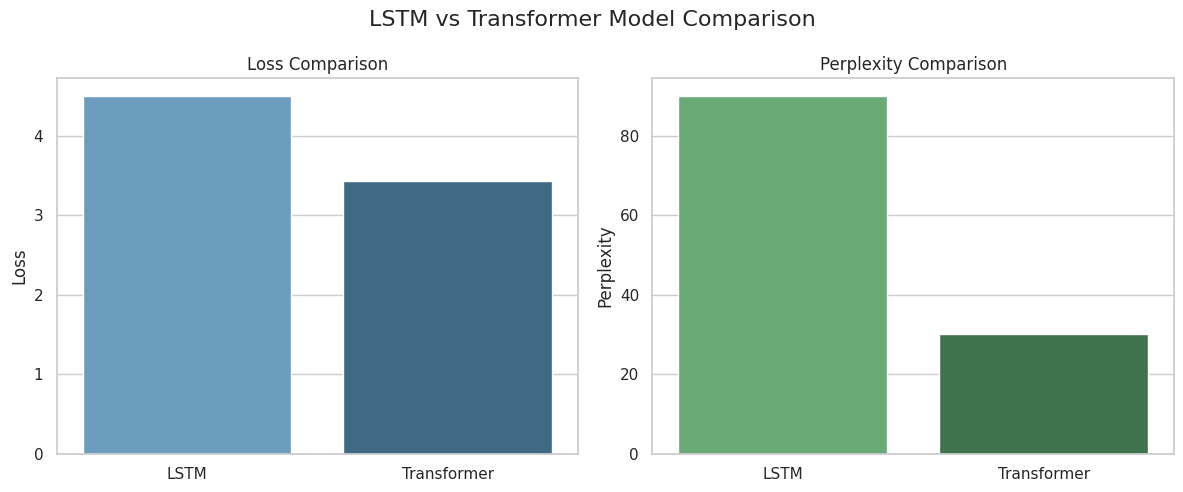

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics from your models
models = ['LSTM', 'Transformer']
losses = [4.5, 3.435]
perplexities = [90, 30.07]

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss comparison
sns.barplot(x=models, y=losses, ax=axes[0], palette='Blues_d')
axes[0].set_title('Loss Comparison')
axes[0].set_ylabel('Loss')

# Perplexity comparison
sns.barplot(x=models, y=perplexities, ax=axes[1], palette='Greens_d')
axes[1].set_title('Perplexity Comparison')
axes[1].set_ylabel('Perplexity')

plt.suptitle('LSTM vs Transformer Model Comparison', fontsize=16)
plt.tight_layout()
plt.show()


In [64]:
from IPython.display import Markdown, display

display(Markdown("""
###  Model Summary

| Feature            | LSTM                     | Transformer (GPT-2)          |
|--------------------|--------------------------|-------------------------------|
| Sequence Handling  | Sequential (one-step)    | Global (self-attention)       |
| Training Time      | Longer                   | Faster with pre-trained model |
| Output Quality     | Short, less coherent     | Long, context-aware           |
| Perplexity         | 90                     | 30.07                          |
"""))



###  Model Summary

| Feature            | LSTM                     | Transformer (GPT-2)          |
|--------------------|--------------------------|-------------------------------|
| Sequence Handling  | Sequential (one-step)    | Global (self-attention)       |
| Training Time      | Longer                   | Faster with pre-trained model |
| Output Quality     | Short, less coherent     | Long, context-aware           |
| Perplexity         | 90                     | 30.07                          |
